# Binomial Asset Pricing Model II
After treating the subject of fast and slow binomial Asset Pricing models, a logical suite would be the parameter choice and optimization. 

Par définition, stock tree may be represented as above
> $S(i,j) = S_0*u^jd^{i-j}$ with $S_0$ being the initial stock price

However, the Binomial tree models may be implemented with the algorithms above, each of them having their own pros and cons:
* CCR (Cox, Ross and Rubinstein)
* JR (Jarrow and Rudd)
* EQP (Equal Probabilities)
* TRG (Trigeorgis)

The case-study will be the same as in the $Binomial Asset Pricing Model$, for the sake of ease. ($C_N,_j = max(S_N,_j-K, 0)$)

In [8]:
!pip install py_vollib

In [9]:
import numpy as np
from py_vollib.black_scholes import black_scholes as bs
import matplotlib.pyplot as plt
plt.style.use('dark_background')

S0 = 100       # Stock Initial
K = 100        # Strike Price
r = 0.06       # Annual Risk Free Rate
N, T = 3, 1    # Number of Steps, Time to Maturity (in years)
sigma = 0.3    # Annualised stock price 
opttype = 'C'  # Option Type 'C'all or 'P'ut

## Part I: CRR Method

The CRR model uses a lattice to represent the possible future prices of the underlying asset. The lattice is constructed by dividing time into equal intervals and calculating the expected price of the underlying asset at each interval. The probability of the asset price moving up or down is also calculated at each interval.

Alternatively, to calculate the up and dawn factors, as well as the p value:

#### $u = e^{\sigma*\sqrt{\Delta t}}$
#### $d = e^{-\sigma*\sqrt{\Delta t}} = \frac{1}{u}$
#### $p = \frac{1}{2} + \frac{r - \frac{1}{2}\sigma^2}{2\sigma}\sqrt{\Delta t}$


In [15]:
def model_crr(K, T, S0, r, N, sigma, opttype='C'):
    
    dt = T/N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1/u
    q = (np.exp(r*dt) - d)/(u - d)
    disc = np.exp(-r*dt)
    
    S = np.zeros(N+1)
    S[0] = S0 * d ** N
    for j in range(1, N+1):
        S[j] = S[j-1] * u/d
        
    C = np.zeros(N+1)
    for j in range(0, N+1):
        C[j] = max(0, S[j] - K)
    
    for i in np.arange(N, 0, -1):
        for j in range(0, i):
            C[j] = disc * (q * C[j+1] + (1-q)*C[j])
    
    return C[0]

model_crr(K, T, S0, r, N, sigma)

14.426398955158174

## Part II: JR Method
In Jarrow and Rudd's method, we take into account the possibility of the stock price moving up or down, as well as the probability of these movements. This makes it a more realistic model of how stock prices behave in the real world. The factors are calculated as shown below:
#### $u = e^{(r - \frac{1}{2}\sigma^2)\Delta t + \sigma*\sqrt{\Delta t}}$ and $d = e^{(r - \frac{1}{2}\sigma^2)\Delta t - \sigma*\sqrt{\Delta t}}$ and $p = \frac{1}{2}$

In [11]:
def model_jr(K, T, S0, r, N, sigma, opttype='C'):
    
    dt = T/N
    u = np.exp((r - 0.5 * sigma**2)*dt + sigma*np.sqrt(dt))
    d = np.exp((r - 0.5 * sigma**2)*dt - sigma*np.sqrt(dt))
    q = 0.5
    disc = np.exp(-r*dt)
    
    S = np.zeros(N+1)
    S[0] = S0 * d ** N
    for j in range(1, N+1):
        S[j] = u * S[j-1]/d
        
    C = np.zeros(N+1)
    for j in range(0, N+1):
        C[j] = max(0, S[j] - K)
    
    for i in np.arange(N, 0, -1):
        for j in range(0, i):
            C[j] = disc * (q * C[j+1] + (1-q)*C[j])
    
    return C[0]

model_jr(K, T, S0, r, N, sigma)

15.633697768928515

## Part III: EQP Method 

As the name indique, The EQP method is a simple and intuitive way to price options, but it assumes that the price of the underlying asset can only go up or down with equal probabilities, which may not always be the case in the real world.

The following formulas will help us to go forth for option pricing:

#### $\Delta x_u = 0.5v\Delta t + 0.5\sqrt{4\sigma^2 \Delta t - 3v^2\Delta t^2}$
#### $\Delta x_d = 1.5v\Delta t - 0.5\sqrt{4\sigma^2 \Delta t - 3v^2\Delta t^2}$


In [12]:
def model_eqp(K, T, S0, r, N, sigma, opttype='C'):
    
    dt = T/N
    nu = r - 0.5 * sigma**2
    sqrted = np.sqrt(4 * (sigma**2) * dt - 3* (nu * dt)**2)
    dxu = 0.5 * nu*dt + 0.5 * sqrted
    dxd = 1.5 * nu*dt - 0.5 * sqrted
    pu, pd = 0.5, 0.5
    disc = np.exp(-r*dt)
    
    S = np.zeros(N+1)
    S[0] = S0 * np.exp(N*dxd) # worst case scenario
    for j in range(1, N+1):
        S[j] = S[j-1] * np.exp(dxu - dxd)
        
    C = np.zeros(N+1)
    for j in range(0, N+1):
        C[j] = max(0, S[j] - K)
    
    for i in np.arange(N, 0, -1):
        for j in range(0, i):
            C[j] = disc * (pu* C[j+1] + pd*C[j])
    
    return C[0]

model_eqp(K, T, S0, r, N, sigma)

15.371587131564217

## Part IV: TRG Method
The Trigeorgis method is considered to be a more accurate method for pricing $American$ options than other numerical methods, such as the Cox-Ross-Rubinstein (CRR) method, because it uses a logarithmic transformation of the stock price, which allows for more accurate pricing of American options when the underlying asset's volatility is high. However, it can be computationally intensive, as it requires the calculation of a large number of nodes in the binomial tree. The calculations are done with following formulas:

#### $\Delta x_u = \sqrt{\sigma^2*\delta t + [(r-0.5\sigma^2)\Delta t]^2} = -\Delta x_d$ 
#### $P_u = 0.5(1 + \frac{(r-0.5\sigma^2)\Delta t}{\Delta x_u}) = 1-P_d$

In [13]:
def model_trg(K, T, S0, r, N, sigma, opttype='C'):
    
    dt = T/N
    nu = r - 0.5 * sigma**2
    dxu = np.sqrt((sigma**2) * dt + (nu * dt)**2)
    dxd = -dxu
    pu = 0.5*(1 + (nu*dt)/dxu)
    pd = 1-pu
    disc = np.exp(-r*dt)
    
    S = np.zeros(N+1)
    S[0] = S0 * np.exp(N*dxd) # worst case scenario
    for j in range(1, N+1):
        S[j] = S[j-1] * np.exp(dxu - dxd)
        
    C = np.zeros(N+1)
    for j in range(0, N+1):
        C[j] = max(0, S[j] - K)
    
    for i in np.arange(N, 0, -1):
        for j in range(0, i):
            C[j] = disc * (pu* C[j+1] + pd*C[j])
    
    return C[0]

model_trg(K, T, S0, r, N, sigma)

15.609266355646284

## Part V: Comparison
All values are saturating in the area approx [15.35,15.65]. which means that for this particular case, all of them are pretty accurate, ut at the same time, their accuracy may vary depending on the use cases (e.g. TRG for American options). For this particular case, it would be interesting to measure their accuracy with Black-Scholes model. 

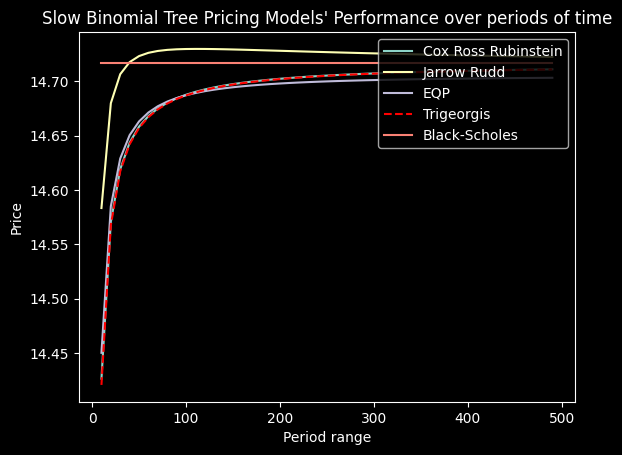

In [17]:
CRR, JR, EQP, TRG = [],[],[],[]
periods = range(10,500,10)
for N in periods:
    CRR.append(model_crr(K,T,S0,r,N,sigma,opttype='C'))
    JR.append(model_jr(K,T,S0,r,N,sigma,opttype='C'))
    EQP.append(model_eqp(K,T,S0,r,N,sigma,opttype='C'))
    TRG.append(model_trg(K,T,S0,r,N,sigma,opttype='C'))
    
BS = [bs('c', S0, K, T, r, sigma) for i in periods]
plt.title("Slow Binomial Tree Pricing Models' Performance over periods of time" )
plt.ylabel('Price')
plt.xlabel('Period range')
plt.plot(periods, CRR, label='Cox Ross Rubinstein')
plt.plot(periods, JR, label='Jarrow Rudd')
plt.plot(periods, EQP, label='EQP')
plt.plot(periods, TRG, 'r--',label='Trigeorgis')
plt.plot(periods, BS,label='Black-Scholes')
plt.legend(loc='upper right')
plt.show()